In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import simtk.openmm as mm
from msmbuilder.decomposition import tICA, PCA

In [3]:
colvar_unbiased = np.loadtxt('../ala4_explicit/COLVAR_md_explicit_10ns')

In [23]:
data = colvar_unbiased[:,1:7]
sumabs=colvar_unbiased[:,-1]

In [24]:
sincos=[]

for i in range(0,len(data)):
    temp=[]
    for j in range(0,6):
        temp.append(np.sin(data[i,j]))
        temp.append(np.cos(data[i,j]))
    sincos.append(temp)

diheds_sincos=np.array(sincos)

In [25]:
X = sumabs
X_dihed = diheds_sincos

xnew_sincos=[]
xnew=[]

for i in range(0,len(X)):
    t1=[]
    t1.append(X[i])
    xnew.append(t1)
    t3=[]
    for j in range(0,12):
        t3.append(X_dihed[i][j])
    xnew_sincos.append(t3)

xnew=np.array(xnew)
xnew_sincos=np.array(xnew_sincos)

print(xnew_sincos[0])
sum(xnew_sincos[:,0])

[-0.67438365 -0.73838113  0.40744875 -0.91322807 -0.9777349   0.20984392
  0.61744359 -0.78661516 -0.95546043  0.29511925  0.70304738 -0.71114301]


-41869.03006544425

In [26]:
x_sincos_centered=xnew_sincos
recenterted_weights=[]
for i in range(0,len(xnew_sincos[0])):
    avg=sum(xnew_sincos[:,i])/len(xnew_sincos)
    recenterted_weights.append(avg)
    print(avg)
    x_sincos_centered[:,i]=x_sincos_centered[:,i]-avg
    
print(x_sincos_centered[0])
recenterted_weights=np.array(recenterted_weights)

-0.8373638540318044
-0.11089574722092439
0.3988736246362931
-0.6151028330760221
-0.8623292715556716
-0.05009631871410182
0.22080465483150075
-0.28863031532459527
-0.8339834437230369
-0.1470649727591676
0.33971750888719676
-0.49980440773681223
[ 0.1629802  -0.62748538  0.00857513 -0.29812524 -0.11540562  0.25994024
  0.39663893 -0.49798485 -0.12147698  0.44218422  0.36332987 -0.21133861]


In [8]:
import sklearn
from sklearn.cross_validation import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_sincos_centered, sumabs, test_size=0.2, random_state=42)

print(x_train.shape, y_train.shape,y_test.shape )

(40000, 12) (40000,) (10001,)


In [9]:
import tensorflow as tf
import numpy as np
print(tf.__version__)
from keras.layers import Lambda, Input, Dense, Concatenate
from keras.models import Model
from keras import backend as K
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model

2.1.0


Using TensorFlow backend.


In [10]:
def circular(args):
    
    z_circular = args

    return z_circular/K.sqrt(K.sum(K.square(z_circular),axis=-1,keepdims=True))

In [11]:
original_dim=12
inputs = Input(shape=(original_dim,),name='encoder_input')
latent_dim = 2
batch_size=100
epochs=500

    
x = Dense(8)(inputs)
x = Dense(4, activation='tanh')(x)
 
z_mean = Dense(latent_dim,activation='tanh',name='z_mean')(x)
z_circular = Lambda(circular, output_shape=(latent_dim,), name='z_circular')(z_mean)

encoder = Model(inputs,  z_circular, name='encoder')
encoder.summary()

latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(4, activation='tanh')(latent_inputs)
x = Dense(8, activation='tanh')(x)
outputs = Dense(original_dim, activation='tanh')(x)    
    
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()


outputs = decoder(encoder(inputs))
vae = Model(inputs, outputs, name='anc-model-plumed')

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
z_mean (Dense)               (None, 2)                 10        
_________________________________________________________________
z_circular (Lambda)          (None, 2)                 0         
Total params: 150
Trainable params: 150
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape   

In [12]:
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim

vae.add_loss(reconstruction_loss)

vae.compile(optimizer='rmsprop')
vae.summary()



Model: "anc-model-plumed"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 12)                0         
_________________________________________________________________
encoder (Model)              (None, 2)                 150       
_________________________________________________________________
decoder (Model)              (None, 12)                160       
Total params: 310
Trainable params: 310
Non-trainable params: 0
_________________________________________________________________


/Users/navya/anaconda3/envs/msm_env/lib/python2.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


In [13]:
autoencoder_train=vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae.save_weights('anc_explicit_plumed.h5')

Train on 40000 samples, validate on 10001 samples
Epoch 1/500
40000/40000 [==============================] - 1s 20us/step - loss: 2.2157 - val_loss: 1.7370
Epoch 2/500
40000/40000 [==============================] - 1s 14us/step - loss: 1.6236 - val_loss: 1.5617
Epoch 3/500
40000/40000 [==============================] - 1s 13us/step - loss: 1.4918 - val_loss: 1.4459
Epoch 4/500
40000/40000 [==============================] - 1s 14us/step - loss: 1.3990 - val_loss: 1.3806
Epoch 5/500
40000/40000 [==============================] - 1s 14us/step - loss: 1.3481 - val_loss: 1.3418
Epoch 6/500
40000/40000 [==============================] - 1s 13us/step - loss: 1.3181 - val_loss: 1.3185
Epoch 7/500
40000/40000 [==============================] - 1s 13us/step - loss: 1.3002 - val_loss: 1.3028
Epoch 8/500
40000/40000 [==============================] - 1s 13us/step - loss: 1.2882 - val_loss: 1.2931
Epoch 9/500
40000/40000 [==============================] - 1s 13us/step - loss: 1.2781 - val_loss: 1.2

40000/40000 [==============================] - 1s 13us/step - loss: 0.9285 - val_loss: 0.9381
Epoch 78/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.9278 - val_loss: 0.9344
Epoch 79/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.9277 - val_loss: 0.9336
Epoch 80/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.9276 - val_loss: 0.9370
Epoch 81/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.9263 - val_loss: 0.9353
Epoch 82/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.9263 - val_loss: 0.9328
Epoch 83/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.9265 - val_loss: 0.9346
Epoch 84/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.9255 - val_loss: 0.9358
Epoch 85/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.9245 - val_loss: 0.9311
Epoch 86/500
40000/40000 [========================

40000/40000 [==============================] - 1s 18us/step - loss: 0.9023 - val_loss: 0.9147
Epoch 154/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.9027 - val_loss: 0.9134
Epoch 155/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.9032 - val_loss: 0.9123
Epoch 156/500
40000/40000 [==============================] - 1s 16us/step - loss: 0.9050 - val_loss: 0.9120
Epoch 157/500
40000/40000 [==============================] - 1s 18us/step - loss: 0.9028 - val_loss: 0.9133
Epoch 158/500
40000/40000 [==============================] - 1s 19us/step - loss: 0.9028 - val_loss: 0.9119
Epoch 159/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.9027 - val_loss: 0.9112
Epoch 160/500
40000/40000 [==============================] - 1s 16us/step - loss: 0.9024 - val_loss: 0.9139
Epoch 161/500
40000/40000 [==============================] - 1s 16us/step - loss: 0.9021 - val_loss: 0.9124
Epoch 162/500
40000/40000 [===============

40000/40000 [==============================] - 1s 14us/step - loss: 0.8985 - val_loss: 0.9051
Epoch 229/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8979 - val_loss: 0.9070
Epoch 230/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8988 - val_loss: 0.9050
Epoch 231/500
40000/40000 [==============================] - 1s 19us/step - loss: 0.9006 - val_loss: 0.9052
Epoch 232/500
40000/40000 [==============================] - 1s 20us/step - loss: 0.8986 - val_loss: 0.9062
Epoch 233/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8982 - val_loss: 0.9056
Epoch 234/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8994 - val_loss: 0.9099
Epoch 235/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8969 - val_loss: 0.9059
Epoch 236/500
40000/40000 [==============================] - 1s 14us/step - loss: 0.8970 - val_loss: 0.9049
Epoch 237/500
40000/40000 [===============

40000/40000 [==============================] - 0s 12us/step - loss: 0.8942 - val_loss: 0.9099
Epoch 304/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8946 - val_loss: 0.9037
Epoch 305/500
40000/40000 [==============================] - 1s 13us/step - loss: 0.8948 - val_loss: 0.9038
Epoch 306/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8950 - val_loss: 0.9068
Epoch 307/500
40000/40000 [==============================] - 0s 11us/step - loss: 0.8949 - val_loss: 0.9223
Epoch 308/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8947 - val_loss: 0.9103
Epoch 309/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8956 - val_loss: 0.9055
Epoch 310/500
40000/40000 [==============================] - 0s 11us/step - loss: 0.8951 - val_loss: 0.9072
Epoch 311/500
40000/40000 [==============================] - 0s 11us/step - loss: 0.8954 - val_loss: 0.9066
Epoch 312/500
40000/40000 [===============

Epoch 379/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8924 - val_loss: 0.9050
Epoch 380/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8925 - val_loss: 0.9038
Epoch 381/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8927 - val_loss: 0.9020
Epoch 382/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8931 - val_loss: 0.9026
Epoch 383/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8919 - val_loss: 0.9006
Epoch 384/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8932 - val_loss: 0.9301
Epoch 385/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8928 - val_loss: 0.9073
Epoch 386/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8925 - val_loss: 0.9044
Epoch 387/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8933 - val_loss: 0.8998
Epoch 388/500
40000/40000 [=

40000/40000 [==============================] - 0s 12us/step - loss: 0.8928 - val_loss: 0.8991
Epoch 455/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8921 - val_loss: 0.9050
Epoch 456/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8911 - val_loss: 0.8986
Epoch 457/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8912 - val_loss: 0.9009
Epoch 458/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8908 - val_loss: 0.8978
Epoch 459/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8912 - val_loss: 0.8972
Epoch 460/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8906 - val_loss: 0.9014
Epoch 461/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8914 - val_loss: 0.9013
Epoch 462/500
40000/40000 [==============================] - 0s 12us/step - loss: 0.8916 - val_loss: 0.9000
Epoch 463/500
40000/40000 [===============

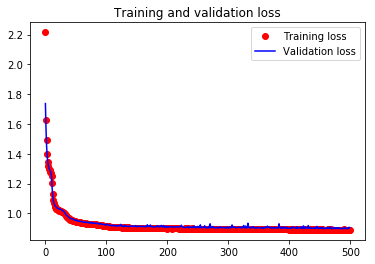

In [14]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs_plot = range(epochs)
plt.figure()
plt.plot(epochs_plot, loss, 'ro', label='Training loss')
plt.plot(epochs_plot, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [15]:
pred_test = vae.predict(x_test)
pred_train = vae.predict(x_train)

In [16]:
z_test = encoder.predict(x_test, batch_size=batch_size)

In [17]:
decoder_test=decoder.predict(z_test,batch_size=batch_size)

In [18]:
z_train = encoder.predict(x_train, batch_size=batch_size)
z_final = encoder.predict(x_sincos_centered, batch_size=batch_size)

In [19]:
weights = vae.get_weights()

In [20]:
np.savetxt('temp',weights[4].T,delimiter=',')

In [85]:
weights[0].T


array([[-0.45681518, -0.901783  , -0.12488701,  0.6447909 , -0.601265  ,
        -0.30163527, -0.49540493,  0.30572858, -0.03488958,  0.5861954 ,
         0.54521513, -0.19418384],
       [-0.48425016, -0.04075143, -1.015309  ,  1.7588074 ,  0.70587015,
        -1.0836976 , -0.30363515,  0.51296747,  0.3576565 ,  0.00819907,
         0.1636586 , -0.75320464],
       [-0.17588894, -0.01381701, -0.04048036,  0.14586262,  0.5614913 ,
        -0.41754997, -0.2663737 , -0.447482  ,  0.1682814 ,  0.2487039 ,
        -0.22189815,  0.01522128],
       [ 0.62883365, -0.6967917 ,  0.06689807, -1.0039129 , -0.25626147,
         0.7016813 ,  0.17510067, -0.33958253,  0.01177449, -0.16196328,
         0.5694954 ,  0.37615612],
       [ 0.65728015, -0.19660504,  0.13105965, -0.12258806, -0.45894518,
         0.2802467 ,  0.43173286, -1.0591838 , -0.16308406,  0.13040999,
         0.30177823, -0.33185565],
       [ 0.1194667 , -0.41913855, -0.56090564,  0.94564545,  0.76566213,
        -0.6401499 ,  

In [93]:
weights[1]

array([ 0.07181888,  0.05036657,  0.01658069, -0.10512199,  0.11134026,
       -0.35332012, -0.37021878, -0.10999041], dtype=float32)

In [99]:
dihed_count=6
phi_count=0
psi_count=0
start_idx=5
count=0
for i in range(0,dihed_count):
    if(count%2==0 and count!=0):
        start_idx+=10
    if(i%2==0):
        phi_count+=1
        print("phi"+str(phi_count)+": TORSION ATOMS="+str(start_idx)+","+str(start_idx+2)+","+str(start_idx+4)+","+str(start_idx+10))
        count+=1
    if(i%2==1):
        psi_count+=1
        print("psi"+str(psi_count)+": TORSION ATOMS="+str(start_idx+2)+","+str(start_idx+2+2)+","+str(start_idx+4+2)+","+str(start_idx+10+2))
        count+=1

print("\n")
start_idx=5
count=0

for i in range(0,dihed_count):
    if(count%2==0 and count!=0):
        start_idx+=10
    if(i%2==0):
        phi_count+=1
        print("ALPHABETA ATOMS1={"+str(start_idx)+","+str(start_idx+2)+","+str(start_idx+4)+","+str(start_idx+10)+"} REFERENCE=1.25 LABEL=c"+str(i+1))
        count+=1
    if(i%2==1):
        psi_count+=1
        print("ALPHABETA ATOMS1={"+str(start_idx)+","+str(start_idx+2)+","+str(start_idx+4)+","+str(start_idx+10)+"} REFERENCE=1.25 LABEL=c"+str(i+1))
        count+=1

print("\n")

print("COMBINE LABEL=sum_abs ARG=c1,c2,c3,c4,c5,c6 POWERS=1,1,1,1,1,1")
print("COEFFICIENTS=0.6228,0.1201,0.5643,0.1102,0.5153,0.0403 PERIODIC=NO")

print("\n")

phi_count=0
psi_count=0
for i in range(0,dihed_count):
    if(i%2==0):
        phi_count+=1
        print("phi"+str(phi_count)+"_sin: MATHEVAL ARG="+"phi"+str(phi_count)+" VAR=t FUNC=sin(t) PERIODIC=NO")
        print("phi"+str(phi_count)+"_cos: MATHEVAL ARG="+"phi"+str(phi_count)+" VAR=t FUNC=cos(t) PERIODIC=NO")    
    if(i%2==1):
        print("psi"+str(phi_count)+"_sin: MATHEVAL ARG="+"psi"+str(phi_count)+" VAR=t FUNC=sin(t) PERIODIC=NO")
        print("psi"+str(phi_count)+"_cos: MATHEVAL ARG="+"psi"+str(phi_count)+" VAR=t FUNC=cos(t) PERIODIC=NO")
        
print("\n")

phi_count=0
psi_count=0
count=0
for i in range(0,dihed_count):
    if(i%2==0):
        phi_count+=1
        print("r"+str(count+1)+": MATHEVAL ARG=phi"+str(phi_count)+"_sin VAR=t FUNC=t-("+str(recenterted_weights[count])+") PERIODIC=NO")
        print("r"+str(count+2)+": MATHEVAL ARG=phi"+str(phi_count)+"_cos VAR=t FUNC=t-("+str(recenterted_weights[count+1])+") PERIODIC=NO")
        count+=2
    if(i%2==1):
        psi_count+=1
        print("r"+str(count+1)+": MATHEVAL ARG=psi"+str(psi_count)+"_sin VAR=t FUNC=t-("+str(recenterted_weights[count])+") PERIODIC=NO")
        print("r"+str(count+2)+": MATHEVAL ARG=psi"+str(psi_count)+"_cos VAR=t FUNC=t-("+str(recenterted_weights[count+1])+") PERIODIC=NO")
        count+=2

print("\n")

layer_count=3

print("ANN ...\n"+
"LABEL=ann\n"+
"ARG=r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12\n"+
"NUM_LAYERS=4\n"+
"NUM_NODES=12,8,4,2\n"+
"ACTIVATIONS=Linear,Tanh,Tanh\n")


for i in range(0,layer_count):
    weight_temp=""

    for j in range(len(weights[i*2].T)):
        for k in range(len(weights[i*2].T[0])):
            weight_temp+=str(weights[i*2].T[j][k])+","
    weight_temp=weight_temp[:-1]
    print("WEIGHTS"+str(i)+"="+str(weight_temp))
    print("\n")

for i in range(0,layer_count):
    bias_temp=""

    for j in range(len(weights[i*2+1])):
        bias_temp+=str(weights[i*2+1][j])+","
    bias_temp=bias_temp[:-1]
    print("BIASES"+str(i)+"="+str(bias_temp))
    print("\n")
print("... ANN\n")
print("\n")
print("METAD ...\n"

 "ARG=ann.node-0,ann.node-1\n"
 "HEIGHT=0.4\n"
 "BIASFACTOR=4\n"
 "TEMP=300.0\n"
 "SIGMA=0.04,0.04\n"
 "GRID_MIN=-4,-4 GRID_MAX=4,4 GRID_BIN=200,200\n"
 "LABEL=WTMetaD\n"
 "FILE=HILLS\n"

 "PACE=1000\n"

 "ACCELERATION\n"

"... METAD\n")
print("\n")
print("PRINT STRIDE=100 ARG=phi1,psi1,phi2,psi2,phi3,psi3,sum_abs,ann.node-0,ann.node-1,WTMetaD.bias,WTMetaD.acc FILE=COLVAR\n")
        

phi1: TORSION ATOMS=5,7,9,15
psi1: TORSION ATOMS=7,9,11,17
phi2: TORSION ATOMS=15,17,19,25
psi2: TORSION ATOMS=17,19,21,27
phi3: TORSION ATOMS=25,27,29,35
psi3: TORSION ATOMS=27,29,31,37


ALPHABETA ATOMS1={5,7,9,15} REFERENCE=1.25 LABEL=c1
ALPHABETA ATOMS1={5,7,9,15} REFERENCE=1.25 LABEL=c2
ALPHABETA ATOMS1={15,17,19,25} REFERENCE=1.25 LABEL=c3
ALPHABETA ATOMS1={15,17,19,25} REFERENCE=1.25 LABEL=c4
ALPHABETA ATOMS1={25,27,29,35} REFERENCE=1.25 LABEL=c5
ALPHABETA ATOMS1={25,27,29,35} REFERENCE=1.25 LABEL=c6


COMBINE LABEL=sum_abs ARG=c1,c2,c3,c4,c5,c6 POWERS=1,1,1,1,1,1
COEFFICIENTS=0.6228,0.1201,0.5643,0.1102,0.5153,0.0403 PERIODIC=NO


phi1_sin: MATHEVAL ARG=phi1 VAR=t FUNC=sin(t) PERIODIC=NO
phi1_cos: MATHEVAL ARG=phi1 VAR=t FUNC=cos(t) PERIODIC=NO
psi1_sin: MATHEVAL ARG=psi1 VAR=t FUNC=sin(t) PERIODIC=NO
psi1_cos: MATHEVAL ARG=psi1 VAR=t FUNC=cos(t) PERIODIC=NO
phi2_sin: MATHEVAL ARG=phi2 VAR=t FUNC=sin(t) PERIODIC=NO
phi2_cos: MATHEVAL ARG=phi2 VAR=t FUNC=cos(t) PERIODIC=NO
psi2_